# Assignment 6 - Sentiment Classification Part 2

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
max_words = 5000
max_len = 200

(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=max_words)


def preprocess(sequences, labels):
    return sequences, labels.astype(np.int32)

train_sequences, train_labels = preprocess(train_sequences, train_labels)
test_sequences, test_labels = preprocess(test_sequences, test_labels)

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
vocabulary = tf.keras.datasets.imdb.get_word_index()
char_to_ind = vocabulary
ind_to_char = {ind: char for (char, ind) in vocabulary.items()}

1641221/1641221 [==============================] - 0s 0us/step


In [4]:
# remember this? doesn't work...
train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))

ValueError: ignored

In [4]:
# we can create a dataset from a python generator. first, we have to write the generator
# this is a very simple one, but we could execute arbitrary python code in here
# (say, loading files from disk and preparing the loaded inputs somehow)
def gen():
    for sequence, label in zip(train_sequences, train_labels):
        yield sequence, label

In [5]:
# we have to tell TF what to expect from the generator ("Tensor Specification")
train_data = tf.data.Dataset.from_generator(gen, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))

# regular .batch wouldn't work because the inputs are different length
# padded batch automatically pads all elements in the batch to the longest length
# per dimension.
# you can also specify different shapes and padding values other than 0.
# padding is always "post"
train_data = train_data.shuffle(25000).padded_batch(32).repeat(5)

In [6]:
lengths = []
for sequence, label in train_data:
    lengths.append(sequence.shape[1])
    #print(sequence.shape, label.shape)
    #input()

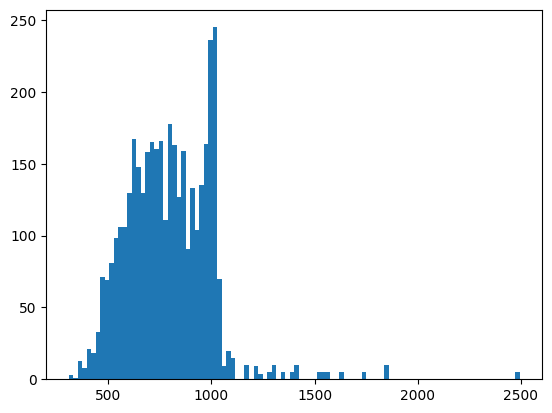

793.7598465473146


In [7]:
plt.hist(lengths, bins=100)
plt.show()

print(np.mean(lengths))

In [8]:
# we have to tell TF what to expect from the generator ("Tensor Specification")
train_data = tf.data.Dataset.from_generator(gen, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))

# alternatively, we can use bucketing. the idea is to define buckets for specific
# sequence lengths, and put all sequences in their corresponding bucket.
# when a batch is requested, first a bucket is selected and then all elements of
# the batch are taken from this bucket.
# this guarantees that all elements in a batch are roughly the same length,
# minimizing the amount of padding.

# here is an example with buckets in steps of 50. all sequences above length 500
# end up in the same bucket. same for sequences below length 50.
# do note that I by no means claim that this is a "good" bucketing. play around with it!
buckets = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bucket_batch_size = [32] * (len(buckets) + 1)
train_data = train_data.bucket_by_sequence_length(lambda sequence, label: tf.shape(sequence)[0],
                                                  bucket_boundaries=buckets, bucket_batch_sizes=bucket_batch_size).repeat(5)

In [9]:
lengths = []
for sequence, label in train_data:
    lengths.append(sequence.shape[1])
    #print(sequence.shape, label.shape)
    #input()

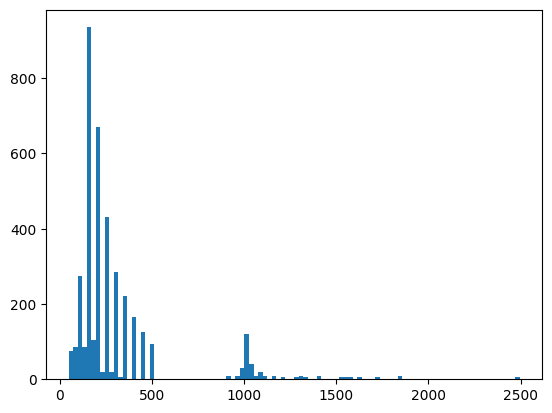

299.38040712468194


In [10]:
plt.hist(lengths, bins=100)
plt.show()

print(np.mean(lengths))

In [11]:
# compare the average batch shapes with the padded_batch example. there, batches are
# often length 800 or so because the longest sequence in the batch happened to
# have that length.
# with bucketing, we get many much smaller batches, meaning more efficient training.
for sequence, label in train_data:
    print(sequence.shape, label.shape)
    input()

(32, 147) (32,)

(32, 198) (32,)

(32, 1038) (32,)

(32, 240) (32,)

(32, 149) (32,)

(32, 199) (32,)

(32, 99) (32,)


KeyboardInterrupt: ignored

In [12]:
# here's a very simple toy example for a keras lstm
# the "hidden dimensions" are just randomly chosen.
# you probably don't want to use a hidden size of 12 =) (but maybe it's actually really good?)


# embedding comes first to replace one-hot vectors.
#    mask_zero=True to prevent computations on padded time steps.
# then an arbitrary number of RNN layers.
# deeper RNN layers take as input sequence the state sequence of the layer before,
# so all layers except the last one should return_sequences=True
# finally, a Dense layer for the output, since the output computation is *not*
# included in the RNN cells; all cells provided by Keras only compute the states
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.LSTM(12, return_sequences=True),
                             tf.keras.layers.LSTM(15),
                             tf.keras.layers.Dense(1)])


# FYI, the third line is the same as the first two lines together.
# the second option can use a much more efficient implementation, it will be SOOO much faster.
# try it yourself!
#rnn_cell = tf.keras.layers.LSTMCell(12)
#rnn = tf.keras.layers.RNN(rnn_cell, return_sequences=False)
rnn = tf.keras.layers.LSTM(12, return_sequences=False)

In [18]:
# calling RNN layers is easy!
# "sequence" is defined above from iterating over the data batches
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 lstm (LSTM)                 (None, None, 12)          1584      
                                                                 
 lstm_1 (LSTM)               (None, 15)                1680      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 103280 (403.44 KB)
Trainable params: 103280 (403.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
test_sequences, test_labels = preprocess(test_sequences, test_labels)

def gen_test():
  for sequence, label in zip(test_sequences, test_labels):
    if len(sequence) <= max_len:
      yield sequence, label

In [16]:
test_data = tf.data.Dataset.from_generator(gen_test, output_signature=(
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32)))
test_data = test_data.bucket_by_sequence_length(lambda sequence, label: tf.shape(sequence)[0],
                                                bucket_boundaries=buckets, bucket_batch_sizes=bucket_batch_size)

In [17]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
3930/3930 [==============================] - 261s 63ms/step - loss: 0.2632 - binary_accuracy: 0.8862 - val_loss: 0.3108 - val_binary_accuracy: 0.8748
Epoch 2/3
3930/3930 [==============================] - 140s 36ms/step - loss: 0.1367 - binary_accuracy: 0.9504 - val_loss: 0.4064 - val_binary_accuracy: 0.8648
Epoch 3/3
3930/3930 [==============================] - 136s 35ms/step - loss: 0.1008 - binary_accuracy: 0.9647 - val_loss: 0.4667 - val_binary_accuracy: 0.8414


Different LSTM Output size

In [22]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.LSTM(25, return_sequences=True),
                             tf.keras.layers.LSTM(16),
                             tf.keras.layers.Dense(1)])

model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
3930/3930 [==============================] - 231s 57ms/step - loss: 0.2979 - binary_accuracy: 0.8702 - val_loss: 0.3009 - val_binary_accuracy: 0.8686
Epoch 2/3
3930/3930 [==============================] - 140s 36ms/step - loss: 0.1675 - binary_accuracy: 0.9350 - val_loss: 0.3910 - val_binary_accuracy: 0.8676
Epoch 3/3
3930/3930 [==============================] - 144s 37ms/step - loss: 0.1214 - binary_accuracy: 0.9548 - val_loss: 0.4621 - val_binary_accuracy: 0.8611


Bidirectional Layer

In [19]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 64, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64),
                             tf.keras.layers.Dense(1)])
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
3930/3930 [==============================] - 239s 59ms/step - loss: 0.2219 - binary_accuracy: 0.9039 - val_loss: 0.4835 - val_binary_accuracy: 0.8634
Epoch 2/3
3930/3930 [==============================] - 135s 34ms/step - loss: 0.0598 - binary_accuracy: 0.9782 - val_loss: 1.0375 - val_binary_accuracy: 0.8331
Epoch 3/3
3930/3930 [==============================] - 136s 34ms/step - loss: 0.0226 - binary_accuracy: 0.9920 - val_loss: 1.0618 - val_binary_accuracy: 0.8640


In [20]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15)),
                             tf.keras.layers.Dense(1)])
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
3930/3930 [==============================] - 319s 77ms/step - loss: 0.2468 - binary_accuracy: 0.8932 - val_loss: 0.3423 - val_binary_accuracy: 0.8759
Epoch 2/3
3930/3930 [==============================] - 223s 57ms/step - loss: 0.1261 - binary_accuracy: 0.9510 - val_loss: 0.4712 - val_binary_accuracy: 0.8668
Epoch 3/3
3930/3930 [==============================] - 221s 56ms/step - loss: 0.0539 - binary_accuracy: 0.9812 - val_loss: 0.6970 - val_binary_accuracy: 0.8562


Different Buckets

In [32]:
train_data = tf.data.Dataset.from_generator(gen, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))
test_data = tf.data.Dataset.from_generator(gen_test, output_signature=(
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32)))

buckets = [10, 100, 200, 300, 400, 500, 600, 700, 750, 1100]
bucket_batch_size = [32] * (len(buckets) + 1)
train_data = train_data.bucket_by_sequence_length(lambda sequence, label: tf.shape(sequence)[0],
                                                  bucket_boundaries=buckets, bucket_batch_sizes=bucket_batch_size)

test_data = test_data.bucket_by_sequence_length(lambda sequence, label: tf.shape(sequence)[0],
                                                bucket_boundaries=buckets, bucket_batch_sizes=bucket_batch_size)

In [33]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.LSTM(12, return_sequences=True),
                             tf.keras.layers.LSTM(15),
                             tf.keras.layers.Dense(1)])
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
786/786 [==============================] - 101s 116ms/step - loss: 0.6708 - binary_accuracy: 0.5554 - val_loss: 0.6813 - val_binary_accuracy: 0.5021
Epoch 2/3
786/786 [==============================] - 32s 40ms/step - loss: 0.5582 - binary_accuracy: 0.6823 - val_loss: 0.3876 - val_binary_accuracy: 0.8449
Epoch 3/3
786/786 [==============================] - 31s 40ms/step - loss: 0.4163 - binary_accuracy: 0.8230 - val_loss: 0.3953 - val_binary_accuracy: 0.8190


mask_zero = False

In [21]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20),
                             tf.keras.layers.LSTM(12, return_sequences=True),
                             tf.keras.layers.LSTM(15),
                             tf.keras.layers.Dense(1)])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
3930/3930 [==============================] - 166s 41ms/step - loss: 0.6199 - binary_accuracy: 0.5993 - val_loss: 0.6797 - val_binary_accuracy: 0.4939
Epoch 2/3
3930/3930 [==============================] - 102s 26ms/step - loss: 0.5502 - binary_accuracy: 0.6889 - val_loss: 0.4428 - val_binary_accuracy: 0.8454
Epoch 3/3
3930/3930 [==============================] - 106s 27ms/step - loss: 0.3676 - binary_accuracy: 0.8487 - val_loss: 0.3722 - val_binary_accuracy: 0.8551


No Bucketing (Post padding)

In [34]:
train_data = tf.data.Dataset.from_generator(gen, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))
train_data = train_data.shuffle(25000).padded_batch(32).repeat(5)

test_data = tf.data.Dataset.from_generator(gen_test, output_signature=(
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32)))

In [35]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.LSTM(12, return_sequences=True),
                             tf.keras.layers.LSTM(15),
                             tf.keras.layers.Dense(1)])
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
   3910/Unknown - 324s 80ms/step - loss: 0.2479 - binary_accuracy: 0.8944

ValueError: ignored